In [1]:
import numpy as np
import torch
import scipy.io
import math
from torch.utils.data import Dataset, DataLoader
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, ELU, Sigmoid, BatchNorm1d as BN, ReLU6 as ReLU6

In [128]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Create Dataset

## Load Data
To compute the spectral efficiency, both transmitter and receiver should be optimized with NN. So the dataset contains F_opt and W_opt.

For unrolling-based methods, the input does not need normalization.

In [2]:
train_layouts = 10000
test_layouts = 2000

In [3]:
data = scipy.io.loadmat('hb_train_144_36.mat')
Fopt_train = data['Fopt'].transpose(2,0,1)
Wopt_train = data['Wopt'].transpose(2,0,1)

In [4]:
test_data = scipy.io.loadmat('hb_test_144_36.mat')
Fopt_test = test_data['Fopt'].transpose(2,0,1)
Wopt_test = test_data['Wopt'].transpose(2,0,1)

## Create Dataset

In [5]:
class PCDataset(torch.utils.data.Dataset):
    def __init__(self, F_opt, W_opt):
        'Initialization' 
        self.F_opt = torch.tensor(F_opt, dtype = torch.cfloat)
        self.W_opt = torch.tensor(W_opt, dtype = torch.cfloat)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.F_opt)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        F_opt = self.F_opt[index]
        W_opt = self.W_opt[index]
        return F_opt, W_opt

In [6]:
train_data = PCDataset(Fopt_train, Wopt_train)
test_data = PCDataset(Fopt_test, Wopt_test)

In [7]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, test_layouts, shuffle=False)

#### Loss function
As the phase shifter matrix is block diagonal, we first define a block diagonal mask## Build Model

#### Loss function
As the phase shifter matrix is block diagonal, we first define a block diagonal mask

In [201]:
N_r, N_t, N_RF, N_s = Wopt_train.shape[1], Fopt_train.shape[1], 18, Fopt_train.shape[2]
Fmask = np.zeros((1,N_t, N_RF) )
Wmask = np.zeros((1,N_r, N_RF) )
for i in range(N_RF):
    Fmask[0,i*N_t//N_RF: (i+1)*N_t//N_RF,i] = np.ones((N_t//N_RF) )
    Wmask[0,i*N_r//N_RF: (i+1)*N_r//N_RF,i] = np.ones((N_r//N_RF) )
Fmask = torch.tensor(Fmask, dtype = torch.cfloat)
Wmask = torch.tensor(Wmask, dtype = torch.cfloat)

The neural network module only needs to output F_BB and W_BB. F_RF and W_RF can be obtained by using (33) in [1].

Note: New version pytorch supports complex valued auto differentiation. Please refer to https://pytorch.org/docs/stable/complex_numbers.html for details. 

In [202]:
def FMF_loss(F_BB, F_opt):
    F_BB = F_BB/torch.norm(F_BB, p = 'fro', dim = [1,2], keepdim = True) * math.sqrt(N_RF * N_s)
    F_RF = F_opt @ F_BB.conj().transpose(1,2)
    F_RF = F_RF/torch.abs(F_RF)
    F_RF = Fmask * F_RF / math.sqrt(N_t)
    return torch.mean(torch.norm(F_opt - F_RF @ F_BB, dim = [1,2])**2)
def WMF_loss(W_BB, W_opt):
    W_BB = W_BB/torch.norm(W_BB, p = 'fro', dim = [1,2], keepdim = True) * math.sqrt(N_RF * N_s)
    W_RF = W_opt @ W_BB.conj().transpose(1,2)
    W_RF = W_RF/torch.abs(W_RF)
    W_RF = Wmask * W_RF / math.sqrt(N_r)
    return torch.mean(torch.norm(W_opt - W_RF @ W_BB, dim = [1,2])**2)

In [203]:
class AltMin_Net(torch.nn.Module):
    def __init__(self):
        super(AltMin_Net, self).__init__()
        self.out_dim = N_RF
        self.lin = Lin(2*N_RF, 2*N_RF)
        
    def complex_lin(self, inp):
        lin_inp = torch.cat((inp.real, inp.imag), axis = -1)
        out = self.lin(lin_inp)
        out_real = torch.unsqueeze(out[:, :, :self.out_dim], axis = -1)
        out_imag = torch.unsqueeze(out[:, :, self.out_dim:self.out_dim*2], axis = -1)
        out = torch.cat((out_real, out_imag), axis = -1)
        return torch.view_as_complex(out)
        
    def forward(self, F_opt, W_opt):
        bs = F_opt.shape[0]
        F_RF = Fmask * torch.randn(bs, N_t, N_RF)
        for i in range(10):
            F_BB = F_RF.transpose(1,2) @ F_opt
            F_BB = F_BB/torch.norm(F_BB, p = 'fro', dim = [1,2], keepdim = True) * math.sqrt(N_RF * N_s)
            F_RF = F_opt @ F_BB.conj().transpose(1,2)
            F_RF = F_RF/torch.abs(F_RF)
            F_RF = Fmask * F_RF / math.sqrt(N_t)
            F_RF = self.complex_lin(F_RF)
            
        W_RF = Wmask * torch.randn(bs, N_r, N_RF)
        for i in range(10):
            W_BB = W_RF.transpose(1,2) @ W_opt
            W_BB = W_BB/torch.norm(W_BB, p = 'fro', dim = [1,2], keepdim = True) * math.sqrt(N_RF * N_s)
            W_RF = W_opt @ W_BB.conj().transpose(1,2)
            W_RF = W_RF/torch.abs(W_RF)
            W_RF = Wmask * W_RF / math.sqrt(N_r)
            W_RF = self.complex_lin(W_RF)
        
        return F_BB, W_BB

## Train and Test

In [204]:
def train(epoch):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for batch_idx, (F_opt_train, W_opt_train) in enumerate(train_loader):
        optimizer.zero_grad()
        Foutput, Woutput = model(F_opt_train, W_opt_train)
        loss = FMF_loss(Foutput, F_opt_train) + WMF_loss(Woutput, W_opt_train)
        loss.backward()
        loss_all += loss.item() * len(F_opt_train)
        optimizer.step()
    return loss_all / len(train_loader.dataset)

In [205]:
def test(loader):
    model.eval()
    correct = 0
    for (F_opt_test, W_opt_test) in loader:
        Foutput, Woutput = model(F_opt_test, W_opt_test)
        loss = FMF_loss(Foutput, F_opt_test) + WMF_loss(Woutput, W_opt_test)
        correct += loss.item() * len(F_opt_test)
    return correct / len(loader.dataset)

In [206]:
model = AltMin_Net()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

In [207]:
record = []
for epoch in range(200):
    train_rate = test(train_loader)
    test_rate = test(test_loader)
    if(epoch % 10 == 0):
        print('Epoch {:03d}, Train Rate: {:.4f}, Test Rate: {:.4f}'.format(
            epoch, train_rate, test_rate))
    record.append([train_rate, test_rate])
    train(epoch)
    scheduler.step()

Epoch 000, Train Rate: 3.0849, Test Rate: 3.0784
Epoch 010, Train Rate: 2.3603, Test Rate: 2.3602
Epoch 020, Train Rate: 1.9490, Test Rate: 1.9539
Epoch 030, Train Rate: 1.6603, Test Rate: 1.6697
Epoch 040, Train Rate: 1.4751, Test Rate: 1.4871
Epoch 050, Train Rate: 1.3468, Test Rate: 1.3566
Epoch 060, Train Rate: 1.2872, Test Rate: 1.2990
Epoch 070, Train Rate: 1.2383, Test Rate: 1.2483
Epoch 080, Train Rate: 1.2166, Test Rate: 1.2292
Epoch 090, Train Rate: 1.1967, Test Rate: 1.2084
Epoch 100, Train Rate: 1.1802, Test Rate: 1.1919
Epoch 110, Train Rate: 1.1912, Test Rate: 1.2015
Epoch 120, Train Rate: 1.1645, Test Rate: 1.1755
Epoch 130, Train Rate: 1.1576, Test Rate: 1.1689
Epoch 140, Train Rate: 1.1517, Test Rate: 1.1627
Epoch 150, Train Rate: 1.1467, Test Rate: 1.1578
Epoch 160, Train Rate: 1.1419, Test Rate: 1.1536
Epoch 170, Train Rate: 1.1386, Test Rate: 1.1500
Epoch 180, Train Rate: 1.1377, Test Rate: 1.1489
Epoch 190, Train Rate: 1.1362, Test Rate: 1.1474


In [208]:
import matplotlib.pyplot as plt

train_losses=[record[i][0] for i in range(len(record))]
test_losses=[record[i][1] for i in range(len(record))]

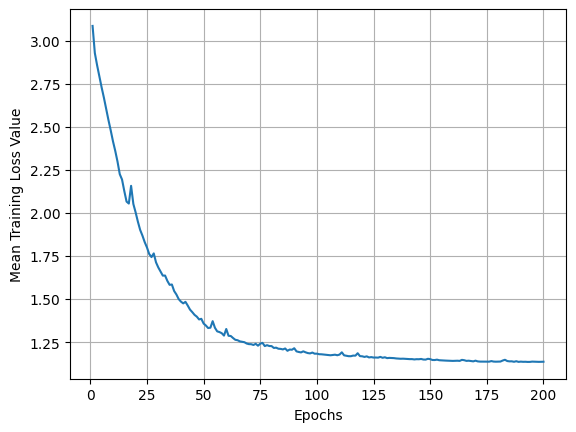

In [209]:
plt.plot(np.arange(len(record))+1,train_losses)
plt.title("")
plt.xlabel('Epochs')
plt.ylabel('Mean Training Loss Value')
plt.grid(True)
plt.show()

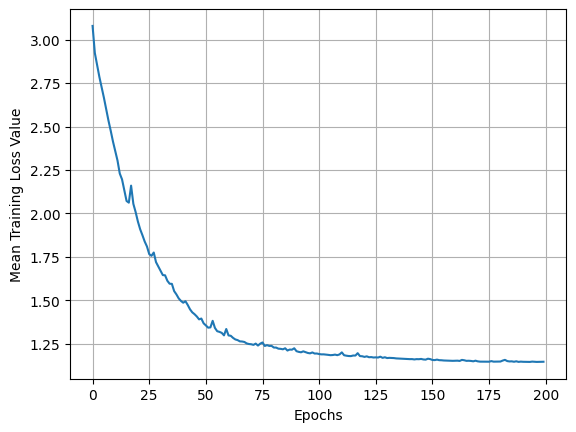

In [210]:
plt.plot(np.arange(len(record)),test_losses)
plt.xlabel('Epochs')
plt.ylabel('Mean Training Loss Value')
plt.grid(True)
plt.show()

## Compute spectral efficiency
The rate computation function is from [1] https://github.com/yuxianghao/Alternating-minimization-algorithms-for-hybrid-precoding-in-millimeter-wave-MIMO-systems/blob/Initial/Narrowband/SDR-AltMin/main_SNR.m

In [211]:
def FBB2FRF(F_BB, F_opt):
    F_BB = F_BB/torch.norm(F_BB, p = 'fro', dim = [1,2], keepdim = True) * math.sqrt(N_RF * N_s)
    F_RF = F_opt @ F_BB.conj().transpose(1,2)
    F_RF = F_RF/torch.abs(F_RF)
    F_RF = Fmask * F_RF / math.sqrt(N_t)
    return F_BB, F_RF

def WBB2WRF(W_BB, W_opt):
    W_BB = W_BB/torch.norm(W_BB, p = 'fro', dim = [1,2], keepdim = True) * math.sqrt(N_RF * N_s)
    W_RF = W_opt @ W_BB.conj().transpose(1,2)
    W_RF = W_RF/torch.abs(W_RF)
    W_RF = Wmask * W_RF / math.sqrt(N_r)
    return W_BB, W_RF

def compute_rate(FBB, FRF, WBB, WRF, H, SNR):
    '''Matlab code: log2(det(eye(Ns) + SNR(s)/Ns * pinv(WRF * WBB) * H(:,:,reali) * FRF * FBB * FBB' * FRF' * H(:,:,reali)' * WRF * WBB))
    '''
    rate = torch.log2(torch.det(torch.eye(N_s) + SNR/N_s * torch.linalg.pinv(WRF @ WBB) @ H @ FRF @ FBB @ FBB.conj().transpose(1,2)
                                         @ FRF.conj().transpose(1,2) @ H.conj().transpose(1,2) @ WRF @ WBB))
    return float(torch.mean(rate).detach().numpy().real)

def rate_test(loader, H):
    model.eval()
    correct = 0
    with torch.no_grad():
        for (F_opt,  W_opt) in loader:
            FBB, WBB = model(F_opt, W_opt)
            FBB, FRF = FBB2FRF(FBB, F_opt)
            WBB, WRF = WBB2WRF(WBB, W_opt)
            
            print('MF loss:', WMF_loss(WBB, W_opt) + FMF_loss(FBB, F_opt))
        
        SNR_dBs = np.arange(-15, 15, 5)
        res_mlp = []
        res_opt = []
        for SNR_dB in SNR_dBs:
            SNR = 10**(SNR_dB/10)
            res_mlp.append(compute_rate(FBB, FRF, WBB, WRF, H, SNR))
    return res_mlp

In [212]:
test_data = scipy.io.loadmat('hb_test_144_36.mat')
H = torch.tensor(test_data['H'].transpose(2,0,1), dtype = torch.cfloat)

In [217]:
import time

tic=time.time()
res_gnn=rate_test(test_loader, H)
toc=time.time()

print((toc-tic)/2000)

MF loss: tensor(1.1461)
0.0003365964889526367


In [214]:
print(list(range(-15,15,5)))
print(res_gnn)

[-15, -10, -5, 0, 5, 10]
[7.227964878082275, 10.356402397155762, 13.613373756408691, 16.914339065551758, 20.22959327697754, 23.549407958984375]


In [215]:
checkpoint={'weights': model.state_dict(),
            'optimizer':optimizer.state_dict()}

torch.save(checkpoint,'results/models/gnn/gnn1_NRF_18.pth')